In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Function to determine the task based on the file path
def get_task_from_path(path):
    if "species-classifier" in path:
        return "species"
    elif "animal-classifier" in path:
        return "animal"
    elif "behaviour-classifier" in path or "behavior-classifier" in path:
        return "behavior"
    else:
        return "unknown"

# Load CSV data and add task and model information
def load_model_data(model_list):
    model_data = []
    for entry in model_list:
        results_path = entry["results_path"]
        model = entry["model"]
        task = get_task_from_path(results_path)
        
        if os.path.exists(results_path):
            df = pd.read_csv(results_path)
            
            # Ensure 'pred' and 'real' are of consistent types
            df['pred'] = df['pred'].astype(str)  # Convert predictions to strings
            df['real'] = df['real'].astype(str)  # Convert ground truth to strings
            
            df['model'] = model
            df['task'] = task
            model_data.append(df)
        else:
            print(f"Warning: File not found - {results_path}")
    return pd.concat(model_data, ignore_index=True) if model_data else pd.DataFrame()

# Calculate metrics for a group (by task and model)
def calculate_metrics_for_group(df):
    pred = df['pred']
    real = df['real']
    metrics = {
        'accuracy': accuracy_score(real, pred),
        'precision': precision_score(real, pred, average='weighted', zero_division=0),
        'recall': recall_score(real, pred, average='weighted', zero_division=0),
        'f1_score': f1_score(real, pred, average='weighted', zero_division=0)
    }
    return metrics

# Aggregate metrics by task and model
def evaluate_models(data):
    grouped_metrics = []
    for (task, model), group in data.groupby(['task', 'model']):
        metrics = calculate_metrics_for_group(group)
        metrics.update({'task': task, 'model': model})
        grouped_metrics.append(metrics)
    return pd.DataFrame(grouped_metrics)

# Visualize metrics with vertical model names in data labels
def visualize_model_performance(metrics_df, metric_name="accuracy"):
    # Pivot the metrics dataframe for easier plotting
    pivot_table = metrics_df.pivot(index='task', columns='model', values=metric_name)

    # Define parameters for bar placement and width
    bar_width = 0.15  # Width of each individual bar
    group_width = bar_width * len(pivot_table.columns) + 0.2  # Space for each group
    x = np.arange(len(pivot_table)) * group_width  # Adjust group spacing

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot each model's bar with adjusted positions
    for i, model in enumerate(pivot_table.columns):
        positions = x + i * bar_width  # Offset for each model within the group
        ax.bar(
            positions,
            pivot_table[model],
            bar_width,
            label=model,
            edgecolor='black',
            alpha=0.85
        )

        # Add data labels
        for pos, value in zip(positions, pivot_table[model]):
            ax.text(
                pos, value + 0.01, 
                f"{value:.2f}", 
                fontsize=10, ha='center', va='bottom'
            )

    # Customize the chart aesthetics
    ax.set_title(f"Model Performance by Task ({metric_name.capitalize()})", fontsize=16, fontweight='bold')
    ax.set_xlabel("Task", fontsize=14)
    ax.set_ylabel(metric_name.capitalize(), fontsize=14)
    ax.set_xticks(x + (len(pivot_table.columns) - 1) * bar_width / 2)  # Center tick under group
    ax.set_xticklabels(pivot_table.index, rotation=45, ha='right', fontsize=12)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # Convert to percentage if applicable
    ax.legend(title="Model", fontsize=12, title_fontsize=14, loc="upper left", bbox_to_anchor=(1.05, 1))
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    # Adjust layout
    plt.tight_layout()
    plt.show()


def replace_text(df, column_name):
    def replace_value(value):
        try:
            float(value)
            return value 
        except (ValueError, TypeError):
            return "-1"
    df[column_name] = df[column_name].apply(replace_value)
    return df

In [8]:
# List of models and results
model_list = [
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/blip_serengeti_-.csv", "model": "BLIP"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/blip_serengeti_pretrained.csv", "model": "BLIP-PRETRAINED"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/clip_serengeti_-.csv", "model": "CLIP"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/clip_serengeti_pretrained.csv", "model": "CLIP-PRETRAINED"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/gpt_serengeti_-.csv", "model": "GPT"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/gemini_serengeti_-.csv", "model": "GEMINI"},

    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/blip_serengeti_seq.csv", "model": "BLIP-SEQ"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/blip_serengeti_pretrained-seq.csv", "model": "BLIP-PRETRAINED-SEQ"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/clip_serengeti_seq.csv", "model": "CLIP-SEQ"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/clip_serengeti_pretrained-seq.csv", "model": "CLIP-PRETRAINED-SEQ"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/gpt_serengeti_seq.csv", "model": "GPT-SEQ"},
    {"results_path": "/data/luiz/dataset/results/behaviour-classifier/gemini_serengeti_seq.csv", "model": "GEMINI-SEQ"},

    {"results_path": "/data/luiz/dataset/results/animal-classifier/blip_serengeti_-.csv", "model": "BLIP"},
    {"results_path": "/data/luiz/dataset/results/animal-classifier/blip_serengeti_pretrained.csv", "model": "BLIP-PRETRAINED"},
    {"results_path": "/data/luiz/dataset/results/animal-classifier/clip_serengeti_-.csv", "model": "CLIP"},
    {"results_path": "/data/luiz/dataset/results/animal-classifier/clip_serengeti_pretrained.csv", "model": "CLIP-PRETRAINED"},
    {"results_path": "/data/luiz/dataset/results/animal-classifier/gpt_serengeti_-.csv", "model": "GPT"},
    {"results_path": "/data/luiz/dataset/results/animal-classifier/gemini_serengeti_-.csv", "model": "GEMINI"},


    {"results_path": "/data/luiz/dataset/results/species-classifier/blip_serengeti_-.csv", "model": "BLIP"},
    {"results_path": "/data/luiz/dataset/results/species-classifier/blip_serengeti_pretrained.csv", "model": "BLIP-PRETRAINED"},
    {"results_path": "/data/luiz/dataset/results/species-classifier/clip_serengeti_-.csv", "model": "CLIP"},
    {"results_path": "/data/luiz/dataset/results/species-classifier/clip_serengeti_pretrained.csv", "model": "CLIP-PRETRAINED"},
    {"results_path": "/data/luiz/dataset/results/species-classifier/gpt_serengeti_-.csv", "model": "GPT"},
    {"results_path": "/data/luiz/dataset/results/species-classifier/gemini_serengeti_-.csv", "model": "GEMINI"},
    {"results_path": "/data/luiz/dataset/results/species-classifier/gemini_serengeti_-.csv", "model": "GEMINI"},
    {"results_path": "/data/luiz/dataset/results/species-classifier/gemini_serengeti_-.csv", "model": "GEMINI"},
]

# Load data
data = load_model_data(model_list)
data = replace_text(data, "pred")

In [9]:
# Evaluate models
metrics_df = evaluate_models(data)
print("Model Metrics:")
print(metrics_df)

Model Metrics:
    accuracy  precision    recall  f1_score      task                model
0   0.076100   0.300360  0.076100  0.121433    animal                 BLIP
1   0.910000   0.910009  0.910000  0.910000    animal      BLIP-PRETRAINED
2   0.798700   0.814774  0.798700  0.795983    animal                 CLIP
3   0.758800   0.759484  0.758800  0.758674    animal      CLIP-PRETRAINED
4   0.832200   0.854582  0.832200  0.830342    animal               GEMINI
5   0.856586   0.869052  0.856586  0.855303    animal                  GPT
6   0.001100   0.166400  0.001100  0.002186  behavior                 BLIP
7   0.701400   0.703998  0.701400  0.701159  behavior      BLIP-PRETRAINED
8   0.755700   0.763650  0.755700  0.756648  behavior  BLIP-PRETRAINED-SEQ
9   0.087900   0.144340  0.087900  0.109262  behavior             BLIP-SEQ
10  0.342500   0.334661  0.342500  0.331741  behavior                 CLIP
11  0.481700   0.487393  0.481700  0.476199  behavior      CLIP-PRETRAINED
12  0.5006

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


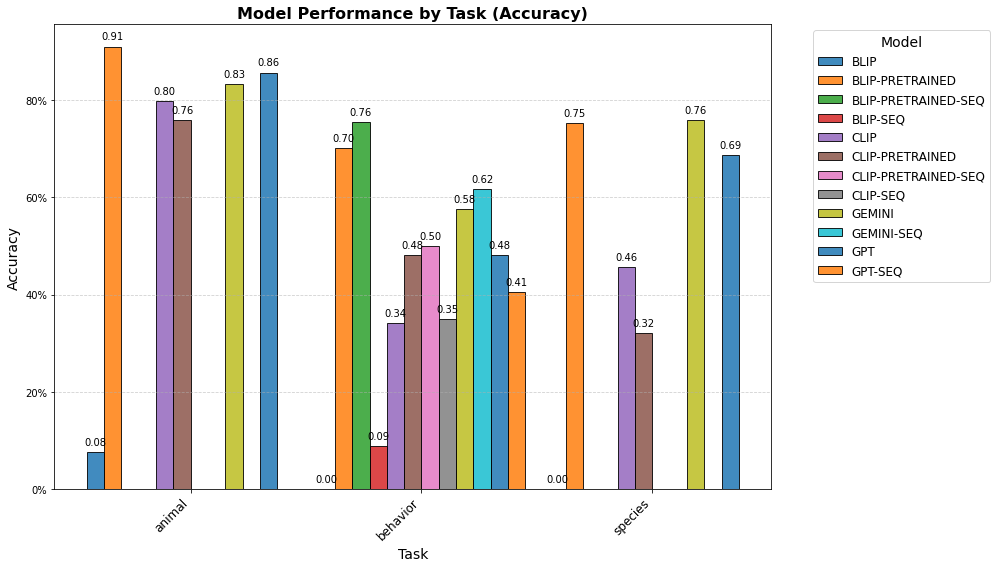

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


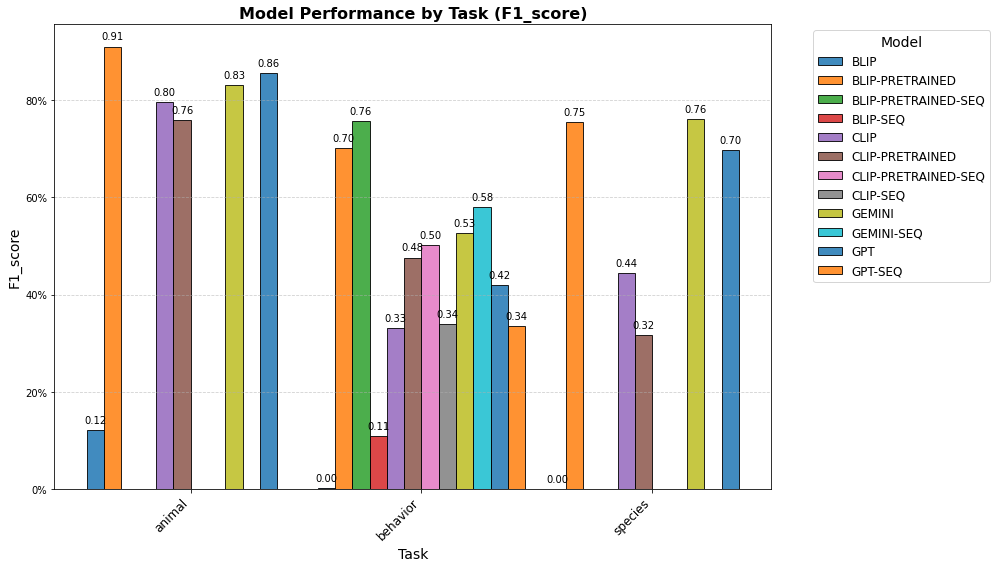

In [22]:
# Visualize metrics (e.g., accuracy)
visualize_model_performance(metrics_df, metric_name="accuracy")
visualize_model_performance(metrics_df, metric_name="f1_score")


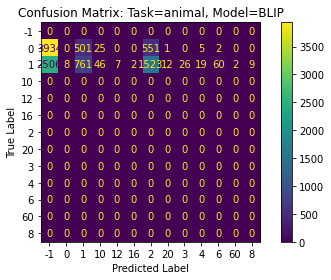

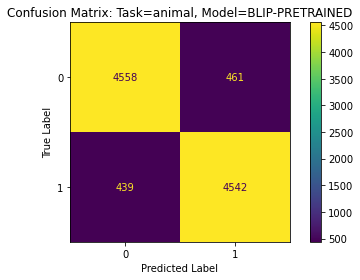

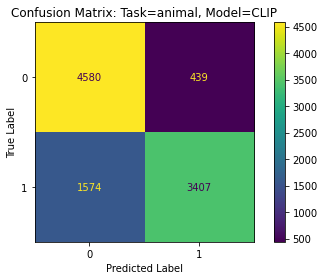

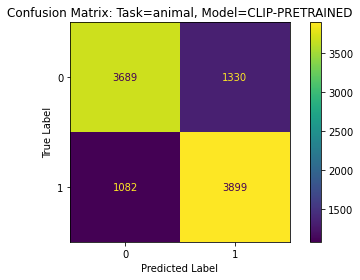

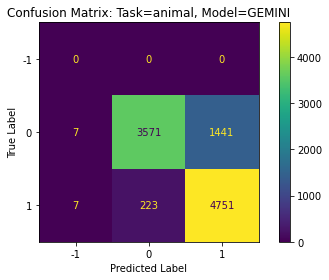

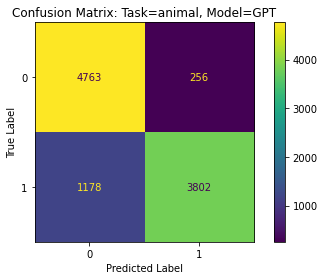

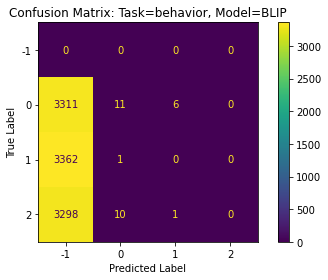

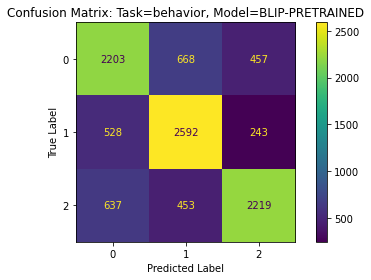

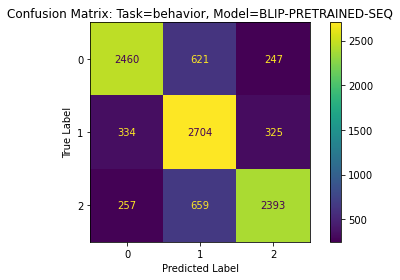

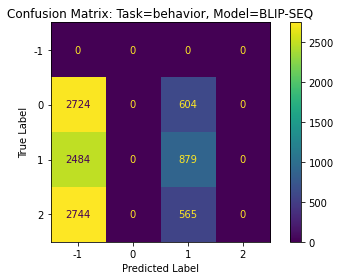

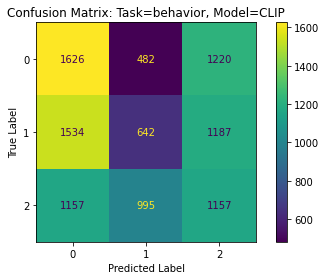

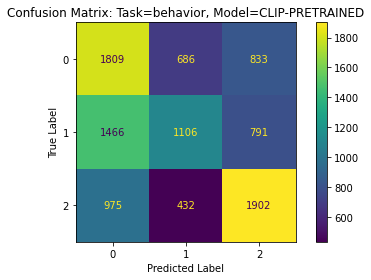

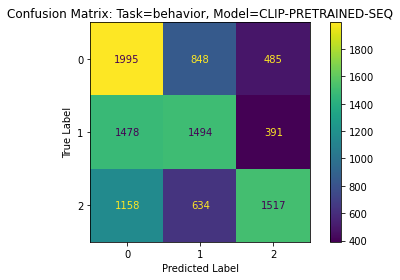

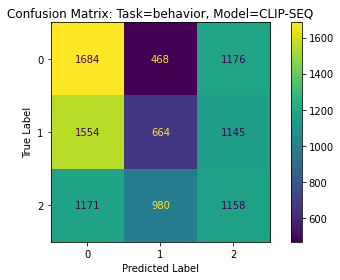

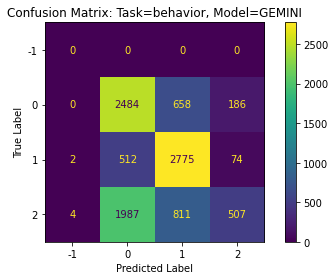

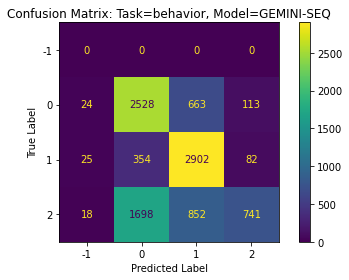

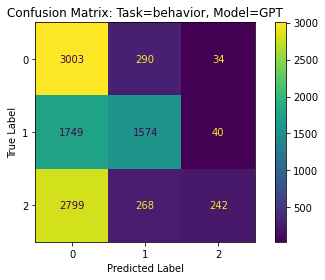

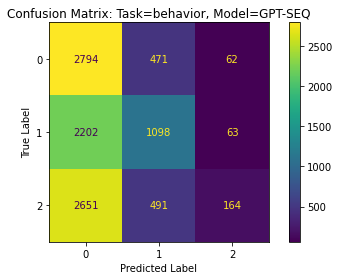

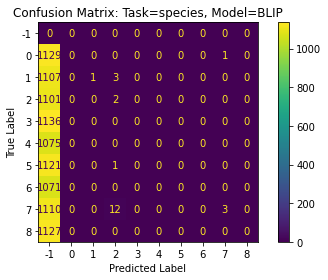

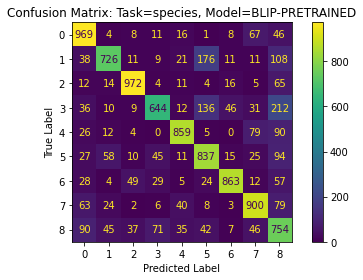

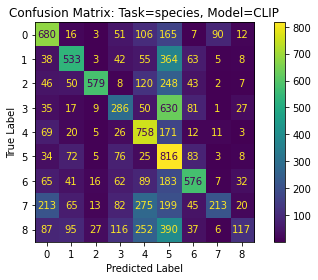

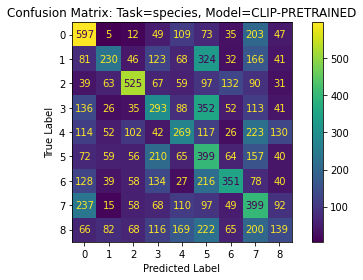

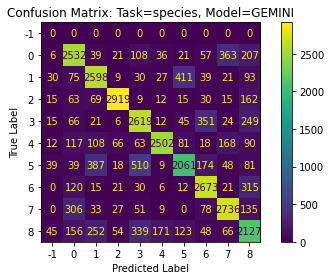

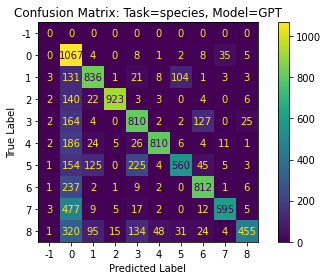

In [14]:
# Importing necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

# Function to plot confusion matrices for each model and task
# Function to plot confusion matrices for each model and task
def plot_confusion_matrices(data):
    grouped = data.groupby(['task', 'model'])
    
    for (task, model), group in grouped:
        pred = group['pred']
        real = group['real']
        
        # Ensure labels cover all unique classes in 'real' and 'pred'
        labels = np.union1d(real.unique(), pred.unique())
        
        # Compute confusion matrix
        cm = confusion_matrix(real, pred, labels=labels)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(cmap="viridis", values_format='d')
        
        plt.title(f"Confusion Matrix: Task={task}, Model={model}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()


plot_confusion_matrices(data)